In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
class Value:
    def __init__(self, data, _children=(), _op = '', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda : None
    
    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        # this so we can do a + 1. if its not a Value class, then wrap it in value
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        # gradient on addition is just 1
        # the += mark for multivariable case, we accumulate the gradient for each node
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __neg__(self):  #-self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __truediv__(self, other): # self/other
        return self * other**-1
    
    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        # derivative total is just local derivative * global derivative
        # the += mark for multivariable case, we accumulate the gradient for each node
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int,float)), "only supporting int/float powers"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other*self.data**(other-1) * out.grad
        
        out._backward = _backward

        return out

    # if we cant do ex, 2.__mul__(a) ==> a.__mul__(2)
    # basily do swapping order of the operator
    def __rmul__(self, other): 
        return self * other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x) +1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out
        
    def backward(self):
        topo = []
        visited = set()

        # topological sorting : kindda like DFS sorting -> go to the bottom of the leaf, then change brance
        # its used so we can automaticly search for the backward propagation
        def build_topo(v):
            if v not in visited: 
                visited.add(v)
                for child in v._prev: 
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [22]:
a = Value(2.0)
b = Value(4.0)

a-b

Value(data = -2.0)

In [7]:
from graphviz import Digraph

# tracing all the nodes and edges from the calculation
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"}) # Lr = left to right
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # creating the rectangular node
        dot.node(name=uid, label= "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            # creating the circle operation node
            dot.node(name=uid + n._op, label= n._op)
            dot.edge(uid+n._op, uid)
    # creatiing edges
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [23]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

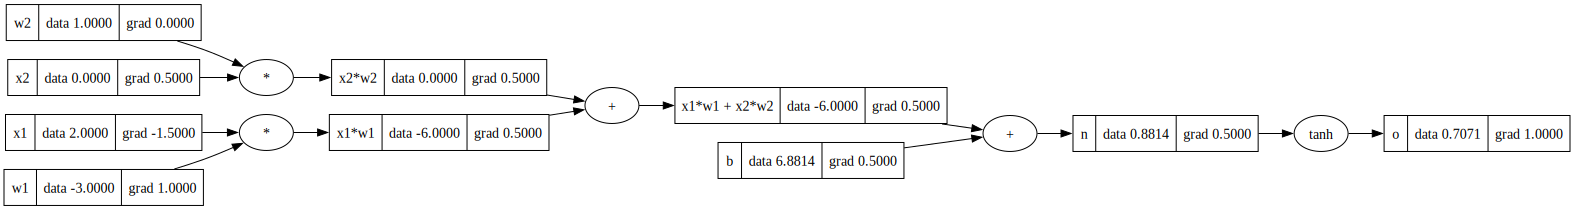

In [24]:
draw_dot(o)

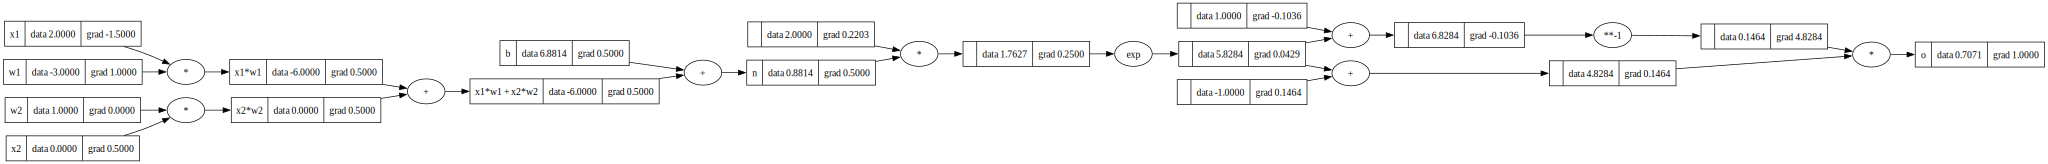

In [25]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e-1) / (e + 1)

o.label = 'o'
o.backward()
draw_dot(o)